In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
raw_data = pd.read_csv('data/Kobe.csv')

In [3]:
raw_data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [6]:
# пропущены только значения в целевой переменной shot_made_flag, исключим их
raw_data = raw_data.dropna()

In [7]:
raw_data['remaining_time'] = raw_data['minutes_remaining'] * 60 + raw_data['seconds_remaining']

# Replace 20 least common action types with value 'Other'
rare_action_types = raw_data['action_type'].value_counts().sort_values().index.values[:20]
raw_data.loc[raw_data['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

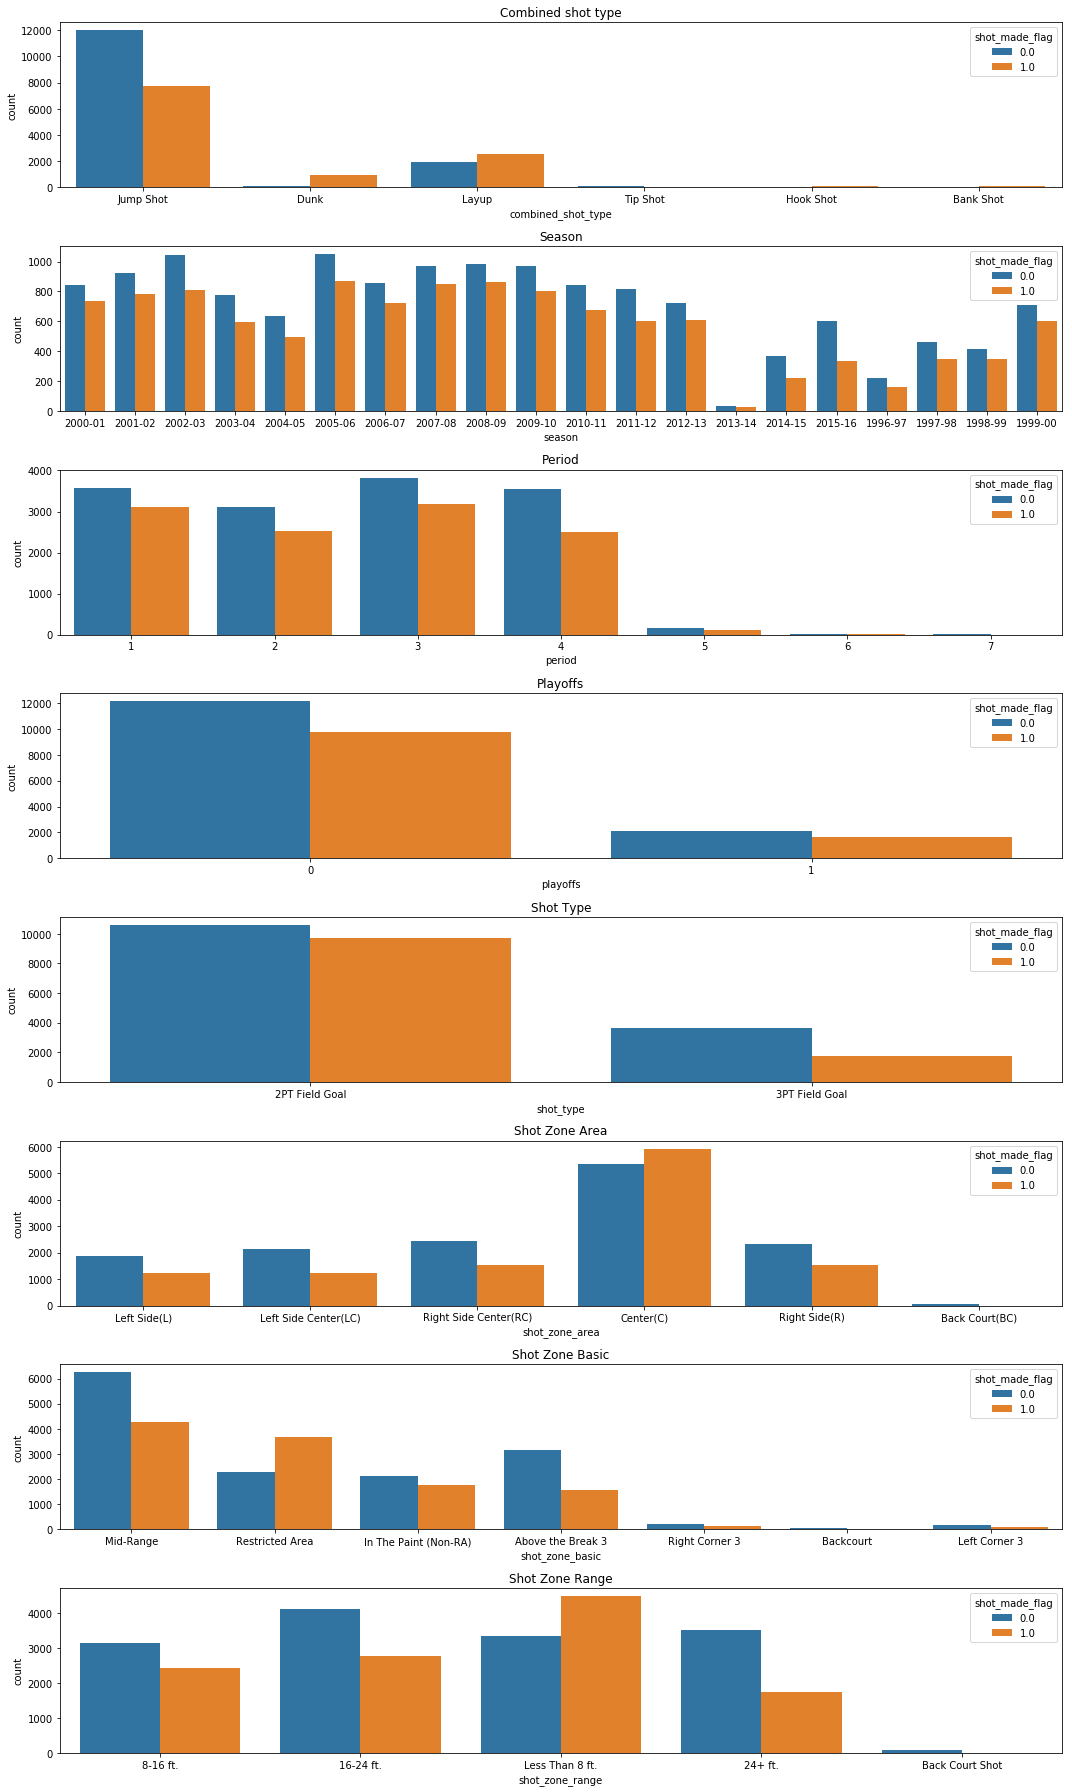

In [8]:
# первоисчтоник - https://www.kaggle.com/khozzy/kobe-shots-show-me-your-best-model

f, axarr = plt.subplots(8, figsize=(15, 25))

sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=raw_data, ax=axarr[0])
sns.countplot(x="season", hue="shot_made_flag", data=raw_data, ax=axarr[1])
sns.countplot(x="period", hue="shot_made_flag", data=raw_data, ax=axarr[2])
sns.countplot(x="playoffs", hue="shot_made_flag", data=raw_data, ax=axarr[3])
sns.countplot(x="shot_type", hue="shot_made_flag", data=raw_data, ax=axarr[4])
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=raw_data, ax=axarr[5])
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=raw_data, ax=axarr[6])
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=raw_data, ax=axarr[7])

axarr[0].set_title('Combined shot type')
axarr[1].set_title('Season')
axarr[2].set_title('Period')
axarr[3].set_title('Playoffs')
axarr[4].set_title('Shot Type')
axarr[5].set_title('Shot Zone Area')
axarr[6].set_title('Shot Zone Basic')
axarr[7].set_title('Shot Zone Range')

#axarr[7].set_title(szr_dict)

plt.tight_layout()
plt.show()

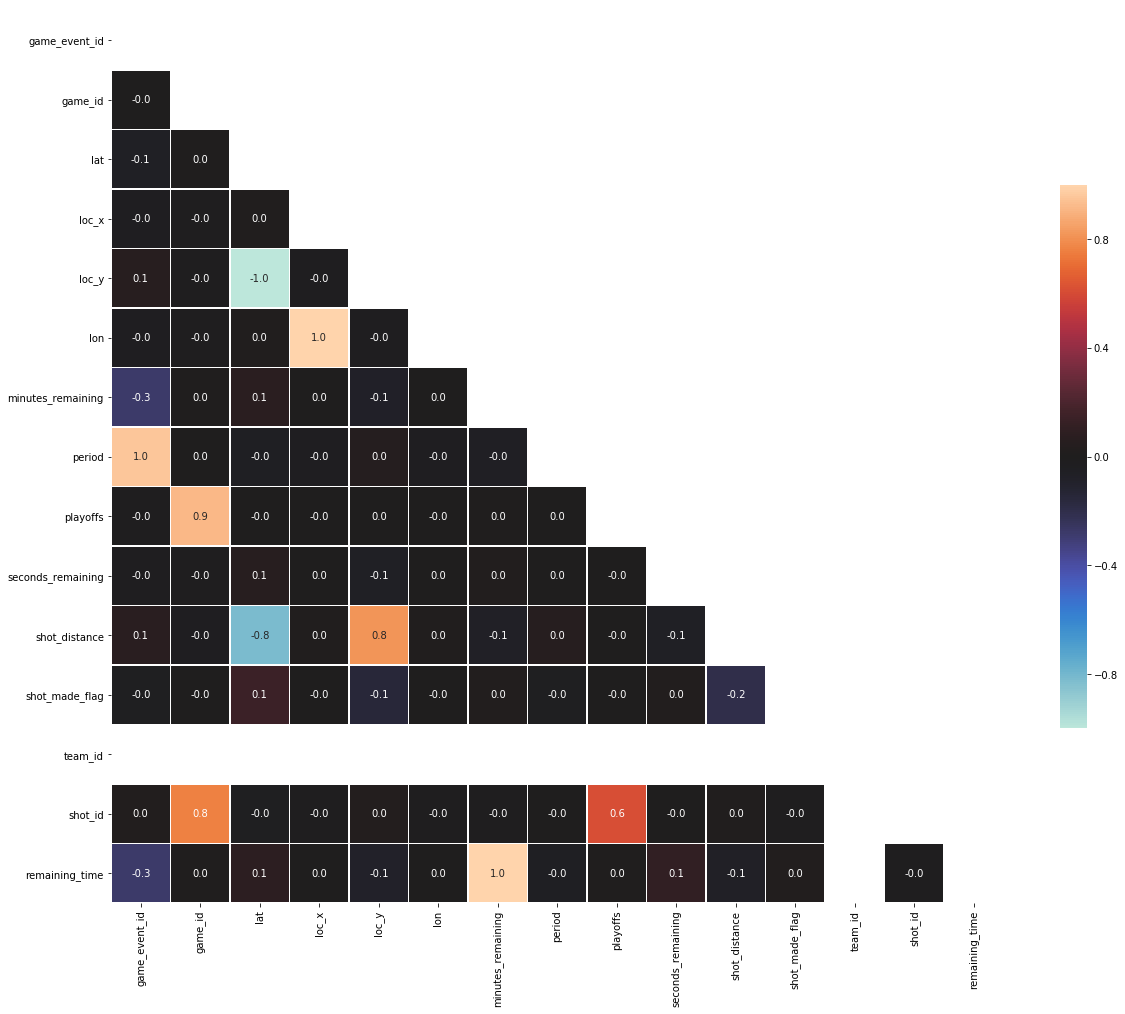

In [9]:
# Stolen with pride у коллег во время лабы :)

corr = raw_data.corr()

plt.figure(figsize=(20,20))
# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [10]:
scaler = StandardScaler()

In [11]:
df_train = raw_data.copy()

cols_to_drop = ['game_event_id', 'game_id', 'team_id', 'game_date', 'shot_id']

df_train = df_train.drop(labels = cols_to_drop, axis = 1)

In [12]:
df_train.head()

,action_type,combined_shot_type,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,...,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,matchup,opponent,remaining_time
1,Jump Shot,Jump Shot,34.0443,-157,0,-118.4268,10,1,0,2000-01,...,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,Los Angeles Lakers,LAL @ POR,POR,622
2,Jump Shot,Jump Shot,33.9093,-101,135,-118.3708,7,1,0,2000-01,...,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,Los Angeles Lakers,LAL @ POR,POR,465
3,Jump Shot,Jump Shot,33.8693,138,175,-118.1318,6,1,0,2000-01,...,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,Los Angeles Lakers,LAL @ POR,POR,412
4,Driving Dunk Shot,Dunk,34.0443,0,0,-118.2698,6,2,0,2000-01,...,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,Los Angeles Lakers,LAL @ POR,POR,379
5,Jump Shot,Jump Shot,34.0553,-145,-11,-118.4148,9,3,0,2000-01,...,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,Los Angeles Lakers,LAL @ POR,POR,572


In [13]:
df_train_y = df_train.shot_made_flag
df_train = df_train.drop(['shot_made_flag'], axis=1)
df_train = pd.get_dummies(df_train)

In [14]:
df_train.shape

(25697, 200)

Text(0,0.5,'explained_variance_ratio_')

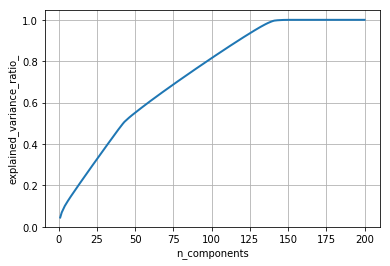

In [15]:
pca = PCA().fit(scaler.fit_transform(df_train))

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [16]:
scaler = StandardScaler()
x_scaled = scaler.fit(df_train)
x_train_scaled=  x_scaled.transform(df_train)

pca = PCA(n_components=97)
pca.fit(x_train_scaled)
X_pca = pca.transform(x_train_scaled)

for i in range(1, X_pca.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.045
n-components=2, explained variance 0.069
n-components=3, explained variance 0.085
n-components=4, explained variance 0.101
n-components=5, explained variance 0.113
n-components=6, explained variance 0.125
n-components=7, explained variance 0.136
n-components=8, explained variance 0.147
n-components=9, explained variance 0.158
n-components=10, explained variance 0.169
n-components=11, explained variance 0.180
n-components=12, explained variance 0.191
n-components=13, explained variance 0.201
n-components=14, explained variance 0.212
n-components=15, explained variance 0.222
n-components=16, explained variance 0.233
n-components=17, explained variance 0.244
n-components=18, explained variance 0.254
n-components=19, explained variance 0.264
n-components=20, explained variance 0.275
n-components=21, explained variance 0.285
n-components=22, explained variance 0.296
n-components=23, explained variance 0.306
n-components=24, explained variance 0.316
n

 около 97 переменных объясняют 80% дисперсии. Как отобрать именно эти 97 переменных?

In [17]:
X = df_train
y = df_train_y

In [18]:
# у линейной регрессии огромные коэффициенты и точка пересечения с осью

lm = LinearRegression().fit(X, y)
print(lm.intercept_)
print(lm.coef_)

y_pred = lm.predict(X)
rss = sum((y_pred-y) ** 2)
R2 = r2_score(y, y_pred)

print("RSS:", rss)
print("R^2:", R2)

841661120390.7262
[-7.21360931e+06 -7.11436157e+06 -7.21360943e+03  7.11436157e+09
  1.89002752e+07 -1.20386615e-02 -7.42425295e-03  3.15004588e+05
  1.86718119e-03 -3.15004587e+05 -3.18374682e+05 -3.18374725e+05
 -3.18374647e+05 -3.18374545e+05 -3.18374578e+05 -3.18375005e+05
 -3.18374692e+05 -3.18374659e+05 -3.18374628e+05 -3.18374847e+05
 -3.18374560e+05 -3.18374903e+05 -3.18374609e+05 -3.18374976e+05
 -3.18374733e+05 -3.18375049e+05 -3.18374686e+05 -3.18374706e+05
 -3.18375178e+05 -3.18375055e+05 -3.18374797e+05 -3.18374734e+05
 -3.18374717e+05 -3.18374801e+05 -3.18374612e+05 -3.18374657e+05
 -3.18374713e+05 -3.18374527e+05 -3.18374731e+05 -3.18374722e+05
 -3.18374641e+05 -3.18374837e+05 -3.18374393e+05 -3.18374696e+05
 -3.18374868e+05 -3.18374888e+05  3.63252578e+05  3.63252674e+05
  3.63252495e+05  3.63252541e+05  3.63252491e+05  3.63251797e+05
 -5.54597517e+02 -5.54623007e+02 -5.54564221e+02 -5.54568875e+02
 -5.54566670e+02 -5.54580610e+02 -5.54589492e+02 -5.54606530e+02
 -5.545

у линейной регрессии очень низкий R2

In [19]:
# у Ридж коэффициенты стали очень маленькими

rg = Ridge(alpha=100).fit(X, y)
print(rg.intercept_)
print(rg.coef_)
y_pred = rg.predict(X)
rss = sum((y_pred-y) ** 2)
R2 = r2_score(y, y_pred)

print("RSS:", rss)
print("R^2:", R2)

0.6774263500349096
[ 1.12297034e-07 -5.08021282e-05 -1.12297031e-04 -5.08021226e-08
 -1.04906939e-05 -1.16633669e-02 -5.80649639e-03  6.81596887e-04
 -3.74448417e-04  5.21552516e-05  3.17042811e-02  1.55872193e-02
  7.23737602e-02  7.97910573e-02  7.60442361e-02 -3.15175165e-02
  6.87942469e-02  4.51464399e-02  3.37017425e-02 -6.70569468e-02
  5.83509495e-02 -5.41900547e-02  3.34938462e-02 -4.28678065e-02
  4.95045654e-02 -1.08171816e-01  1.13349608e-01  2.03097981e-02
 -3.27429823e-01 -2.75456704e-01 -1.72559632e-02  8.38828120e-02
  1.21915237e-02 -2.73852946e-02  1.74880620e-02  3.36543191e-02
  4.65540985e-03  6.47604471e-02  9.87083019e-02  1.45608168e-02
  8.25063316e-02  2.84472606e-03 -1.25087768e-01  2.61584037e-02
 -2.31505462e-02 -3.99926643e-02  5.75253356e-02  1.82091764e-01
 -4.33379920e-02 -4.58410039e-02 -1.94189342e-02 -1.31019170e-01
  1.42868721e-03 -2.53442346e-02  2.55621190e-02  2.19736319e-02
  2.63929234e-02  1.18374234e-02  5.42907107e-03 -1.02934350e-02
  1.31

у Ридж также все плохо как у линейной регрессии

In [20]:
# у Лассо все коэффициенты кроме одного занулились

ls = Lasso().fit(X, y)
print(ls.intercept_)
print(ls.coef_)

y_pred = ls.predict(X)
rss = sum((y_pred-y) ** 2)
R2 = r2_score(y, y_pred)

print("RSS:", rss)
print("R^2:", R2)

0.501759804834995
[ 0.00000000e+00 -0.00000000e+00 -7.01249537e-04 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.61116399e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.000

что-то пошло не так 0_о

In [21]:
X = df_train
y = df_train_y
clf = LinearRegression() # use any model

scores = cross_validate(
    clf, X, y, cv=3, scoring=('roc_auc'), return_train_score=True
)

scores

# что выводится в test_score, если я оцениваю 3 раза train?

{'fit_time': array([0.27155304, 0.2085011 , 0.22765088]),
 'score_time': array([0.01389003, 0.0127821 , 0.01279807]),
 'test_score': array([0.64389228, 0.68948963, 0.55544786]),
 'train_score': array([0.7088533 , 0.71071789, 0.7078291 ])}

In [22]:
clf = Ridge() # use any model

scores = cross_validate(
    clf, X, y, cv=3, scoring=('roc_auc'), return_train_score=True
)

scores

{'fit_time': array([0.12712717, 0.11140299, 0.10740709]),
 'score_time': array([0.01370382, 0.01350117, 0.01901388]),
 'test_score': array([0.69154038, 0.69067374, 0.68462083]),
 'train_score': array([0.70877681, 0.71074168, 0.70785097])}

In [23]:
clf = Lasso() # use any model

scores = cross_validate(
    clf, X, y, cv=3, scoring=('roc_auc'), return_train_score=True
)

scores

{'fit_time': array([0.12930799, 0.10353494, 0.11164498]),
 'score_time': array([0.01291275, 0.01300311, 0.01921225]),
 'test_score': array([0.57739946, 0.58793646, 0.59595187]),
 'train_score': array([0.59201769, 0.58631783, 0.58254658])}

### 4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [24]:
X = df_train
y = df_train_y
x_train, x_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42)

In [25]:
clf = LinearRegression() # use any model

scores_train = cross_validate(
    clf, x_train, y_train, cv = 3, scoring=('roc_auc'), return_train_score=True
)

print(scores_train.get('test_score'))

scores_test = cross_validate(
    clf, x_test, y_test, cv = 3, scoring=('roc_auc'), return_train_score=True
)

print(scores_test.get('test_score'))

[0.69020422 0.69654694 0.69308506]
[0.67239329 0.67658395 0.66195251]


In [26]:
clf = Ridge() # use any model

scores_train = cross_validate(
    clf, x_train, y_train, cv = 3, scoring=('roc_auc'), return_train_score=True
)

print(scores_train.get('test_score'))

scores_test = cross_validate(
    clf, x_test, y_test, cv = 3, scoring=('roc_auc'), return_train_score=True
)

print(scores_test.get('test_score'))

[0.69051135 0.69657054 0.69328425]
[0.67406668 0.67773526 0.66254525]


In [27]:
clf = Lasso() # use any model

scores_train = cross_validate(
    clf, x_train, y_train, cv = 3, scoring=('roc_auc'), return_train_score=True
)

print(scores_train.get('test_score'))

scores_test = cross_validate(
    clf, x_test, y_test, cv = 3, scoring=('roc_auc'), return_train_score=True
)

print(scores_test.get('test_score'))

[0.57363851 0.59282844 0.59644698]
[0.58128601 0.59348174 0.57812614]


Ридж оказался лучшим среди худших